## Question 3: Imbalanced Classification

In [2]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Load the data set

In [3]:
data = torch.load('malaria.pt')  
class_names = data["class_names"]
Xtrain = data['Xtrain']
Xtest = data['Xtest']
Ytrain = data['Ytrain']
Ytest = data['Ytest']

 ### Question 3(a): Class Proportions

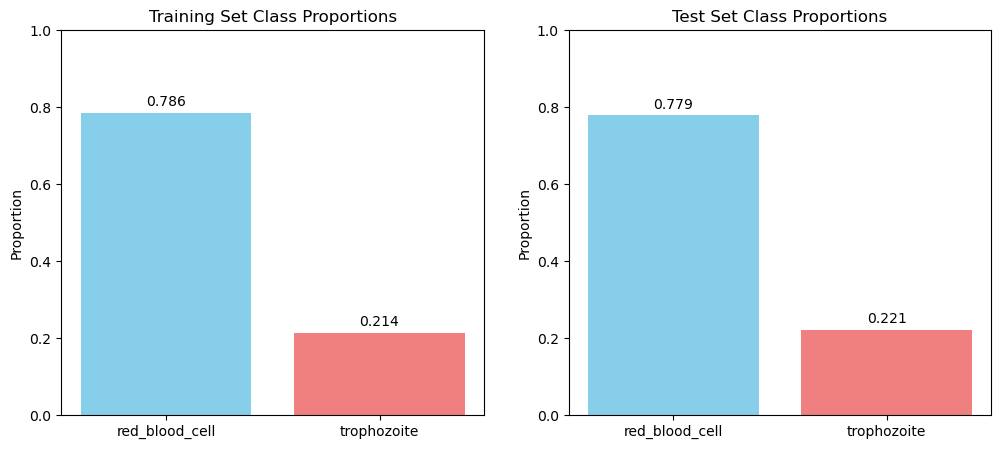

In [4]:
#Add code for 3(a) here
tr_ct = torch.bincount(Ytrain)
tr_frac = tr_ct.float() / tr_ct.sum()
tes_ct = torch.bincount(Ytest)
tes_frac = tes_ct.float() / tes_ct.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(class_names, tr_frac.tolist(), color=['skyblue', 'lightcoral'])
ax1.set_title('Training Set Class Proportions')
ax1.set_ylabel('Proportion')
ax1.set_ylim(0, 1)
for i, v in enumerate(tr_frac.tolist()):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

ax2.bar(class_names, tes_frac.tolist(), color=['skyblue', 'lightcoral'])
ax2.set_title('Test Set Class Proportions')
ax2.set_ylabel('Proportion')
ax2.set_ylim(0, 1)
for i, v in enumerate(tes_frac.tolist()):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
plt.show()


### Define the model

In [5]:
class MLP(nn.Module):
    def __init__(self, D, K1, K2, C):
        super(MLP, self).__init__()

        self.device  = "cuda" if torch.cuda.is_available() else "cpu" 
        self.fc1 = nn.Linear(D, K1).to(self.device)
        self.fc2 = nn.Linear(K1, K2).to(self.device)
        self.fc3 = nn.Linear(K2, C).to(self.device)
        self.activation = self.activation = torch.relu

    def forward(self, X):
        n = X.size()[0]
        X = (X-self.mean)/self.std
        h1 = self.activation(self.fc1(X.reshape(n,-1)))
        h2 = self.activation(self.fc2(h1))
        g = self.fc3(h2)
        return g
    
    def predict_proba(self,X):
        N      = X.shape[0]
        logits = self.forward(X.reshape(N,-1))
        probs  = F.softmax(logits, dim=-1)
        return(probs)
    
    def predict(self,X):
        N      = X.shape[0]
        logits = self.forward(X.reshape(N,-1))
        return(torch.argmax(logits, dim=-1))

    def fit(self,Xtrain, Ytrain, lr=0.01, num_epochs=25, batch_size=512):

        N            = Xtrain.shape[0]
        Xtrain       = Xtrain.reshape(N,-1).to(self.device)
        Ytrain       = Ytrain.to(self.device)

        self.mean    = Xtrain.mean(dim=0, keepdim=True).to(self.device)
        self.std     = Xtrain.std(dim=0, keepdim=True).to(self.device)

        dataset      = TensorDataset(Xtrain, Ytrain)
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)        
        optimizer    = optim.Adam(self.parameters(), lr=lr)

        # Start training loop loop
        for epoch in tqdm(range(num_epochs)): #(loop for every epoch)

            running_loss = 0.0
            running_err  = 0.0

            #Load batches
            for inputs, labels in train_loader:

                #Zero the gradient
                optimizer.zero_grad()

                #Run the forward pass
                out      = self.forward(inputs)
                lp       = F.log_softmax(out, dim=-1)
                loss     = F.nll_loss(lp, labels, reduction='mean')
                _, preds = torch.max(out, 1)

                # get gradient and update the network weights
                loss.backward()
                optimizer.step()

                #Accumulate the loss
                running_loss += loss.item()
                running_err += torch.sum(preds != labels.data).item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_err = running_err / len(train_loader.dataset) 

            # Print progress
            print(f'[Train {epoch+1}] Loss: {epoch_loss:.8f} Err: {epoch_err:.8f}%')

### Question 3(b): Learn the base model and compute results

In [6]:
#Add code for 3(b) here
D,K1,K2,C = Xtrain.shape[1] * Xtrain.shape[2] * Xtrain.shape[3],20,20,len(class_names) 
model = MLP(D, K1, K2, C)
model.fit(Xtrain, Ytrain, lr=0.0001, num_epochs=50, batch_size=512)
model.eval()
with torch.no_grad():
    te_preds = model.predict(Xtest)
    te_preds = te_preds.cpu()
    yte_cpu = Ytest.cpu()

true_preds = (te_preds == yte_cpu).sum().item()
overall_er = 1 - (true_preds / len(yte_cpu))
print()
print(f"Overall Error Rate: {overall_er:.4f}")

ers = []
for c in range(C):
    mask = (yte_cpu == c)
    samps = mask.sum().item()
    
    if samps > 0:
        right = ((te_preds == yte_cpu) & mask).sum().item()
        er = 1 - (right / samps)
        ers.append(er)
        print(f"Error Rate for {class_names[c]}: {er:.4f}")
    else:
        ers.append(0.0)
        print(f"Error Rate for {class_names[c]}: N/A (no samples)")


ber = np.mean(ers)
print(f"Balanced Error Rate: {ber:.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

[Train 1] Loss: 0.00146708 Err: 0.69210010%
[Train 2] Loss: 0.00127374 Err: 0.43326791%
[Train 3] Loss: 0.00114112 Err: 0.30004907%
[Train 4] Loss: 0.00104832 Err: 0.23846909%
[Train 5] Loss: 0.00097689 Err: 0.20412169%
[Train 6] Loss: 0.00091767 Err: 0.18621197%
[Train 7] Loss: 0.00086503 Err: 0.17934249%
[Train 8] Loss: 0.00081745 Err: 0.17369971%
[Train 9] Loss: 0.00077700 Err: 0.16511286%
[Train 10] Loss: 0.00074134 Err: 0.16143278%
[Train 11] Loss: 0.00071095 Err: 0.15554465%
[Train 12] Loss: 0.00068499 Err: 0.14892051%
[Train 13] Loss: 0.00066351 Err: 0.14474975%
[Train 14] Loss: 0.00064467 Err: 0.14057900%
[Train 15] Loss: 0.00062871 Err: 0.13763494%
[Train 16] Loss: 0.00061399 Err: 0.13567223%
[Train 17] Loss: 0.00060109 Err: 0.13199215%
[Train 18] Loss: 0.00058960 Err: 0.13199215%
[Train 19] Loss: 0.00057816 Err: 0.12855741%
[Train 20] Loss: 0.00056737 Err: 0.12610402%
[Train 21] Loss: 0.00055701 Err: 0.12389598%
[Train 22] Loss: 0.00054717 Err: 0.12168793%
[Train 23] Loss: 0.

### Question 3(c): Update model to use balanced nll and compute results

In [7]:
#Add code for 3(c) here
D,K1,K2,C = Xtrain.shape[1] * Xtrain.shape[2] * Xtrain.shape[3],20,20,len(class_names)
bal_mtp = MLP(D, K1, K2, C)
bal_mtp.fit(Xtrain, Ytrain, lr=0.0001, num_epochs=50, batch_size=512)
bal_mtp.eval()
with torch.no_grad():
    bal_te_preds = bal_mtp.predict(Xtest)
    bal_te_preds = bal_te_preds.cpu()
    Yte_cpu = Ytest.cpu()


bal_true_preds = (bal_te_preds == Yte_cpu).sum().item()
bal_overall_er = 1 - (bal_true_preds / len(Yte_cpu))

print()
print(f"Overall Error Rate: {bal_overall_er:.4f}")

bal_ers = []
for c in range(C):
    mask = (Yte_cpu == c)
    samps = mask.sum().item()
    
    if samps > 0:
        right = ((bal_te_preds == Yte_cpu) & mask).sum().item()
        er = 1 - (right / samps)
        bal_ers.append(er)
        print(f"Error Rate for {class_names[c]}: {er:.4f}")
    else:
        bal_ers.append(0.0)
        print(f"Error Rate for {class_names[c]}: N/A (no samples)")

bal_ber = np.mean(bal_ers)
print(f"Balanced Error Rate: {bal_ber:.4f}")

base_results = {
    'overall_error': overall_er,
    'class_errors': ers,
    'balanced_error': ber
}

balanced_results = {
    'overall_error': bal_overall_er,
    'class_errors': bal_ers,
    'balanced_error': bal_ber
}

  0%|          | 0/50 [00:00<?, ?it/s]

[Train 1] Loss: 0.00121572 Err: 0.21540726%
[Train 2] Loss: 0.00107488 Err: 0.21368989%
[Train 3] Loss: 0.00098624 Err: 0.21221786%
[Train 4] Loss: 0.00091927 Err: 0.20534838%
[Train 5] Loss: 0.00086200 Err: 0.19234544%
[Train 6] Loss: 0.00081347 Err: 0.17173700%
[Train 7] Loss: 0.00077336 Err: 0.15554465%
[Train 8] Loss: 0.00073891 Err: 0.14622179%
[Train 9] Loss: 0.00070871 Err: 0.13591757%
[Train 10] Loss: 0.00068261 Err: 0.12953876%
[Train 11] Loss: 0.00065981 Err: 0.12536801%
[Train 12] Loss: 0.00063954 Err: 0.12193327%
[Train 13] Loss: 0.00062128 Err: 0.12046124%
[Train 14] Loss: 0.00060415 Err: 0.11751717%
[Train 15] Loss: 0.00058853 Err: 0.11506379%
[Train 16] Loss: 0.00057370 Err: 0.11285574%
[Train 17] Loss: 0.00056053 Err: 0.11064769%
[Train 18] Loss: 0.00054792 Err: 0.10843965%
[Train 19] Loss: 0.00053559 Err: 0.10770363%
[Train 20] Loss: 0.00052478 Err: 0.10647694%
[Train 21] Loss: 0.00051376 Err: 0.10181551%
[Train 22] Loss: 0.00050336 Err: 0.10132483%
[Train 23] Loss: 0.


Base Model:
  Overall Error Rate: 0.0900
  Balanced Error Rate: 0.1544
  red_blood_cell Error Rate: 0.0389
  trophozoite Error Rate: 0.2699

Balanced Model:
  Overall Error Rate: 0.0753
  Balanced Error Rate: 0.1339
  red_blood_cell Error Rate: 0.0289
  trophozoite Error Rate: 0.2389


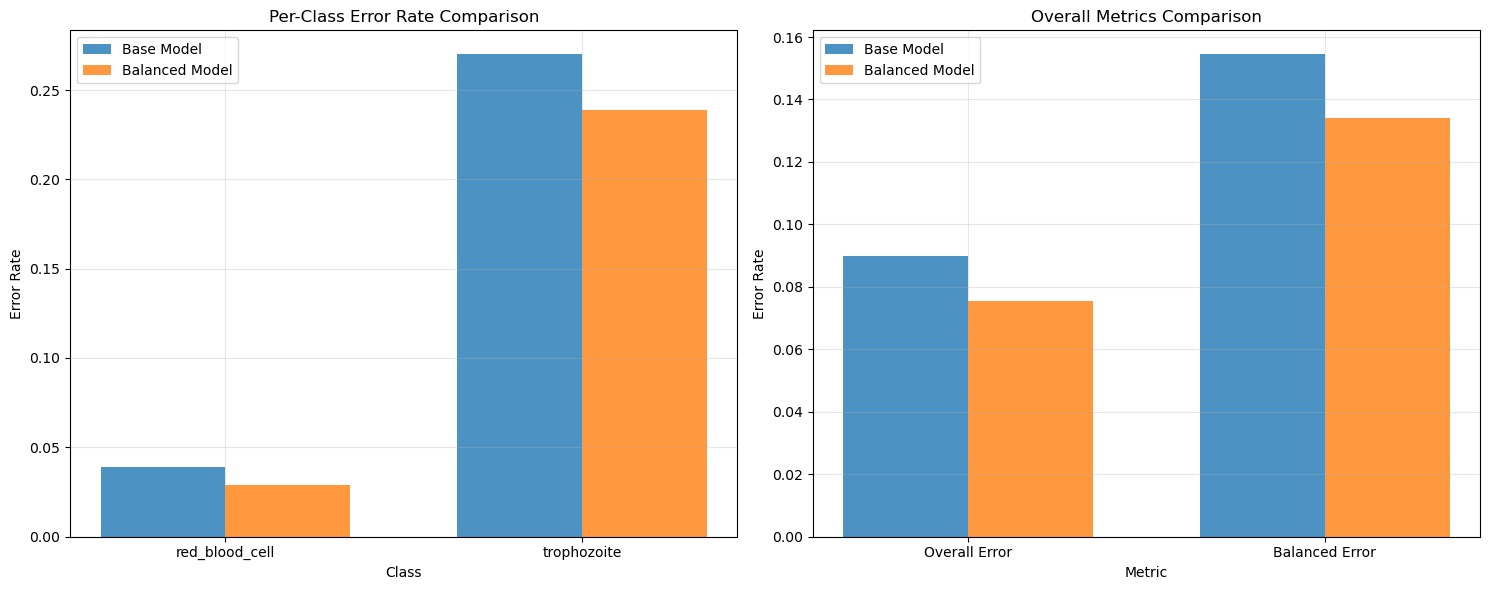

In [10]:
### Question 3(d): Analysis and Comparison

print(f"\nBase Model:")
print(f"  Overall Error Rate: {base_results['overall_error']:.4f}")
print(f"  Balanced Error Rate: {base_results['balanced_error']:.4f}")
for i, class_name in enumerate(class_names):
    print(f"  {class_name} Error Rate: {base_results['class_errors'][i]:.4f}")

print(f"\nBalanced Model:")
print(f"  Overall Error Rate: {balanced_results['overall_error']:.4f}")
print(f"  Balanced Error Rate: {balanced_results['balanced_error']:.4f}")
for i, class_name in enumerate(class_names):
    print(f"  {class_name} Error Rate: {balanced_results['class_errors'][i]:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
x = np.arange(len(class_names))
width = 0.35

ax1.bar(x - width/2, base_results['class_errors'], width, label='Base Model', alpha=0.8)
ax1.bar(x + width/2, balanced_results['class_errors'], width, label='Balanced Model', alpha=0.8)
ax1.set_xlabel('Class')
ax1.set_ylabel('Error Rate')
ax1.set_title('Per-Class Error Rate Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(class_names)
ax1.legend()
ax1.grid(True, alpha=0.3)
metrics = ['Overall Error', 'Balanced Error']
base_metrics = [base_results['overall_error'], base_results['balanced_error']]
balanced_metrics = [balanced_results['overall_error'], balanced_results['balanced_error']]

x2 = np.arange(len(metrics))
ax2.bar(x2 - width/2, base_metrics, width, label='Base Model', alpha=0.8)
ax2.bar(x2 + width/2, balanced_metrics, width, label='Balanced Model', alpha=0.8)
ax2.set_xlabel('Metric')
ax2.set_ylabel('Error Rate')
ax2.set_title('Overall Metrics Comparison')
ax2.set_xticks(x2)
ax2.set_xticklabels(metrics)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
